# Developing an AI application

In this project, I trained an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


First, we import all the libraries we will need.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install Pillow
!pip install PIL
!pip install image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
# We start by importing all the packages we will need, as well as set up some parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import time
import copy
import numpy as np
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
from PIL import Image
import torchvision

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the data

We use `torchvision` to load the data, split between a training and a validation set. We'll apply some transformations to the training set, to produce a more general model and avoid overfitting.

Since we will be using Resnet152, a pre-trained network, some additional pre-processing is necessary: make sure the input data is resized 224x224 pixels, and normalize the means and standard deviations of the images to the values present in the ImageNet dataset (for the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`).

In [0]:
data_dir = 'drive/My Drive/Trainings/PyTorch Challenge/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])}

In [0]:
dirs = {'train': train_dir, 
        'valid': valid_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) 
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=16, 
                                              shuffle=True) 
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

### Label mapping

We'll also need to load in a mapping from category label to category name, which can be found in `cat_to_name.json`.

In [0]:
import json

with open('drive/My Drive/Trainings/PyTorch Challenge/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. 

In [0]:
# We start by checking whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# We leverage Resnet152
model = models.resnet152(pretrained=True)

In [0]:
# From there, we need to freeze the parameters of our convulational layers
for param in model.parameters():
    param.requires_grad = False

In [0]:
# We then build a new classifier, using ReLU activations
# We have 102 categories of flowers in our cat_to_name dictionary, so 102 outputs possible
# The input size is 2048 (due to the choice of Resnet152 specifically)
# We will use the log_softmax for more precision
# We choose 1 hidden layer, with 1,000 units

classifier = nn.Sequential(OrderedDict([
                          ('dropout', nn.Dropout(0.2)),
                          ('fc1', nn.Linear(2048, 1000)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.4)),
                          ('fc2', nn.Linear(1000, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.fc = classifier

In [0]:
# We write a function for our validation pass
# We will use this in the training of our model to visualize the validation accuracy
def validation(model, validateloader, criterion):
    
    # We run our validation on the GPU as well
    model.to(device)
    validation_loss = 0
    accuracy = 0
    for images, labels in validateloader:
        
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        validation_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return validation_loss, accuracy

In [0]:
# We write a function to train our network, which we can re-use easily changing the hyperparameters

def train_model(model, criterion, optimizer, scheduler,    
                                      num_epochs, device=device):
  '''
  INPUT:
  model: a model instance we want to train
  criterion: the loss function 
  optimizer: which optimizer we want to use
  scheduler: the scheduler to adapt our learning rate
  num_epochs: the number of epochs
  device: whether we want to train on a CPU or GPU
  
  OUTPUT:
  a trained model instance
  '''
  
  # We train our network, including a validation pass inside
  # We print every 20 steps to have visibility somewhat regularly in our model


  # We send our model to cuda if available
  model.to(device)
  
  # We initialize various values
  epochs = num_epochs
  steps = 0
  running_loss = 0
  print_every = 20
  valid_loss_min = np.Inf
  best_acc = 0.0
  
  for e in range(epochs):
      # We make sure we are in training mode to make sure dropout is activated
      # We send the inputs and the labels to cuda as well if available
      # We take a scheduler step to change our learning rate as we train
      if scheduler != None:
        scheduler.step()
      model.train()
      for images, labels in dataloaders['train']:
          images, labels = images.to(device), labels.to(device)
          steps += 1

          optimizer.zero_grad()

          output = model.forward(images)
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()


          if steps % print_every == 0:
              # We put the network in evaluation mode, to turn off dropout, 
              # otherwise we will have particularly low accuracy
              model.eval()

              # Turn off gradients for validation
              with torch.no_grad():
                  validation_loss, accuracy = validation(model, dataloaders['valid'], criterion)

              print("Epoch: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                    "Validation Loss: {:.3f}.. ".format(validation_loss/len(dataloaders['valid'])),
                    "Validation Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

              running_loss = 0
              
              if validation_loss/len(dataloaders['valid']) <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                validation_loss/len(dataloaders['valid'])))
                torch.save(model.state_dict(), 'model_flowers.pt')
                valid_loss_min = validation_loss/len(dataloaders['valid'])
                best_acc = accuracy/len(dataloaders['valid'])

              # Make sure training is back on
              model.train()
  print('Best accuracy: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(torch.load('model_flowers.pt'))
  return model

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Number of epochs
eps=10

In [0]:
model_ft = train_model(model, criteria, optimizer, sched, eps, device)

Epoch: 1/10..  Training Loss: 4.428..  Validation Loss: 4.297..  Validation Accuracy: 0.100
Validation loss decreased (inf --> 4.297430).  Saving model ...


KeyboardInterrupt: ignored

In [0]:
# Once we reach a certain validation accuracy. after 15 epochs, 
# we train the entire model (i.e. unfreeze the convolutional layers)
for param in model_ft.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model_ft.parameters(), lr=0.00001)
criteria = nn.NLLLoss()
sched = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
eps = 7

best_model = train_model(model_ft, criteria, optimizer, sched, eps, device)

Epoch: 1/7..  Training Loss: 0.656..  Validation Loss: 0.240..  Validation Accuracy: 0.944
Validation loss decreased (inf --> 0.239533).  Saving model ...
Epoch: 1/7..  Training Loss: 0.528..  Validation Loss: 0.230..  Validation Accuracy: 0.945
Validation loss decreased (0.239533 --> 0.230495).  Saving model ...
Epoch: 1/7..  Training Loss: 0.580..  Validation Loss: 0.221..  Validation Accuracy: 0.951
Validation loss decreased (0.230495 --> 0.220670).  Saving model ...
Epoch: 1/7..  Training Loss: 0.498..  Validation Loss: 0.223..  Validation Accuracy: 0.950
Epoch: 1/7..  Training Loss: 0.586..  Validation Loss: 0.217..  Validation Accuracy: 0.956
Validation loss decreased (0.220670 --> 0.217330).  Saving model ...
Epoch: 1/7..  Training Loss: 0.527..  Validation Loss: 0.211..  Validation Accuracy: 0.960
Validation loss decreased (0.217330 --> 0.211206).  Saving model ...
Epoch: 1/7..  Training Loss: 0.560..  Validation Loss: 0.213..  Validation Accuracy: 0.948
Epoch: 1/7..  Training 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# We save the mapping of indices to class as an attribute to our model
# We also save the inverse mapping to be able to do everything we want

best_model.class_to_idx = cat_to_name
best_model.idx_to_class = {v: k for k, v in cat_to_name.items()}

In [0]:
# We define our checkpoint

checkpoint = {'input_size': best_model.fc.fc1.in_features,
              'output_size': best_model.fc.fc2.out_features,
              'activation_function': nn.ReLU(),
              'hidden_layer': best_model.fc.fc1.out_features,
              'epochs': 17,
              'dropout': nn.Dropout(0.3),
              'output': nn.LogSoftmax(dim = 1),
              'learning_rate': 0.001,
              'class_to_idx': best_model.class_to_idx,
              'idx_to_class': best_model.idx_to_class,
              'optimizer_state': optimizer.state_dict,
              'state_dict': best_model.state_dict(),
              'arch': 'resnet152'}

torch.save(checkpoint, 'drive/My Drive/Trainings/PyTorch Challenge/checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# We write a function that loads the checkpoint and rebuilds the model

def load_checkpoint(filepath, model_type = 'resnet152'):
    ''' It takes a checkpoint and a model type (from Torchvision) and rebuilds the model
    '''
    # We first load our pre-trained model and freeze its parameters again
    if model_type == 'resnet152':
        model = models.resnet152(pretrained=True)
    
    
    for param in model.parameters():
        param.requires_grad = False
    
    # We then load our checkpoint, which contains information on the classifier which we need to build again
    checkpoint = torch.load(filepath)
    
    # We start by loading the architecture of the classifier again
    classifier = nn.Sequential(OrderedDict([
                            ('dropout', checkpoint['dropout']),
                            ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layer'])),
                            ('relu1', checkpoint['activation_function']),
                            ('dropout1', checkpoint['dropout']),
                            ('fc2', nn.Linear(checkpoint['hidden_layer'], checkpoint['output_size'])),
                            ('output', checkpoint['output'])
                          ]))
    
    # We then load some additional elements
    model.fc = classifier
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']
    model.lr = checkpoint['learning_rate']
    optimizer.state_dict = checkpoint['optimizer_state']
    
    model.eval()
    
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def get_image(file_path):
    ''' Takes a string file path for an image as its input,
        returns a PIL image as its output
    '''
    image = Image.open(file_path)
    
    return image

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # We resize the images to make sure there are all 224 x 224 pixels
    # We first create a thumbnail if the shortest size is 256 pixels
    if min(image.size) <= 256:
        image.thumbnail((224,224))
    
    
    # We then crop out the center 224 x 224 portion of the image
    width, height = image.size   

    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2

    image = image.crop((left, top, right, bottom))
    
    # We convert the PIL image to a NumPy array and change the color 
    
    np_image = np.array(image)/255
    
    # We normalize
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_normalized = (np_image - mean)/ std
    
    # Finally we transpose to make sure the color channel is the right dimension
    image = image_normalized.transpose((2,0,1))
    
    return image
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        The model input should be a checkpoint we want to use
    '''
    model = load_checkpoint(model)
    
    model.eval()
    
    # We get the image thanks to our function using PIL
    image = get_image(image_path)
    
    # We process the image and convert it to a tensor
    
    processed_image = process_image(image)
    processed_image = torch.from_numpy(processed_image).float()
    
    # We calculate the probabilities for the different classes using log-softmax
    
    processed_image.unsqueeze_(0)
    with torch.no_grad():
        output = model.forward(processed_image)

    ps = torch.exp(output)
    
    
    # We only display the top k classes and their probabilities
    # We can first get the indices for these classes
    
    topk_probs = torch.topk(ps, topk, dim = 1)[0]
    topk_probs = topk_probs.numpy()
    topk_idx = torch.topk(ps, topk, dim = 1)[1]
    topk_idx += 1 # We need to add one to match the index to the category names
    
    
    # Then we use the mapping to get the category names, and convert everything to lists
    topk_classes = []
    topk_probs = topk_probs.tolist()
    
    for i in range(topk):
        topk_classes.append(model.class_to_idx[str(topk_idx.numpy()[:,i].item())])
        
    
    return topk_probs, topk_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

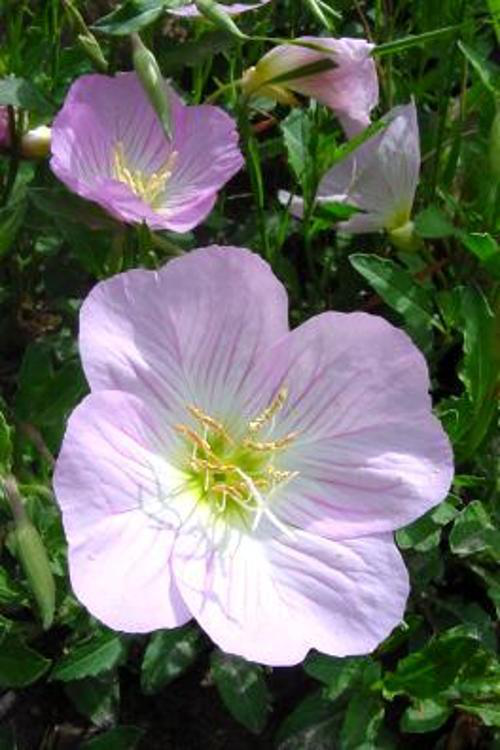

In [0]:
# As a sanity check, we display a flower with the associated probabilities
# First the flower, chosen to be a pink primrose

test_flower_path = 'drive/My Drive/Trainings/PyTorch Challenge/flowers/valid/1/image_06749.jpg'
checkpoint_path = 'drive/My Drive/Trainings/PyTorch Challenge/checkpoint.pth'

probs, classes = predict(test_flower_path, checkpoint_path)

get_image(test_flower_path)

<Container object of 5 artists>

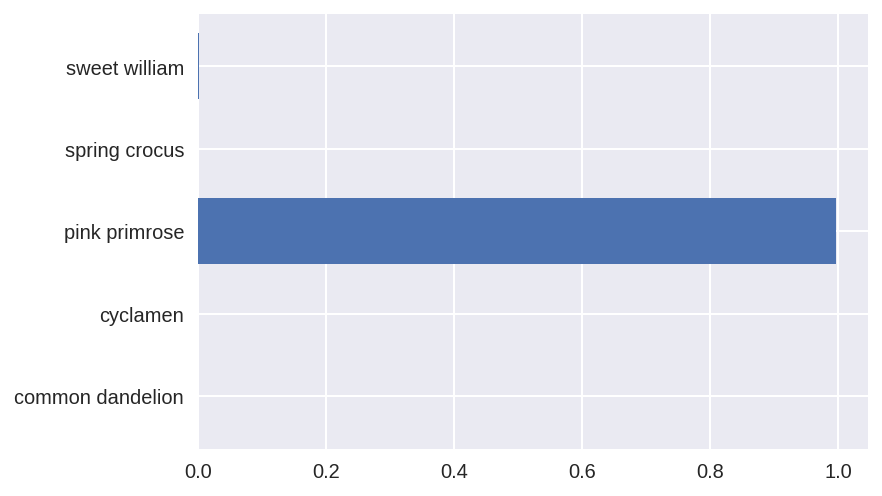

In [0]:
# Then we display the probabilities. This flower seems indeed to be a pink primrose

plt.barh(y = classes, width = probs[0])